# Simulating the Dynamics of a Volatile Pheromone Field

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#### Dynamics

The pheromone field follows $$\partial_t c(\vec{x}, t) = k_+ \rho_a(\vec{x},t) - k_-c + D \nabla^2 c$$ where:
- $ c(\vec{x}, t)$: is the concentration of the field at coordinates $\vec{x}$, at time $t$.
- $\rho_a(\vec{x},t)$: Gaussian Kernel convolved over the locations of the ant agents heading back.

#### Implicit Integration

In an implicit scheme, ignoring reinforcement: $$c^{n+1} = c^n + \Delta t(-k_- c^{n+1} + D\nabla^2c^{n+1})$$
and

$$(1+\Delta t k_-) c^{n+1} - D\Delta t\nabla^2c^{n+1} = c^n$$

after discretizing field into a grid and ravelling it into a vector $\vec{c}^n$,

$$((1 +\Delta t k_-) I - D\Delta t L)\vec c^{n+1} = \vec c^n$$

where $I$ is the ientity matrix of appropriate sign and $L$ is the matrix that computes the approximate laplacian with finite differences.

#### Non-Dimensional Quantities:
- Let the $r$ and $v_a$ be the size and speed of the agent respectively.
- $r$ sets the length scale for the simulation and $\tau = r/v_a$ sets the timescale.
- The coordinates $\vec{x}$ can be expressed as $\vec{x} = (u\cdot r, v \cdot r) = r \cdot \vec{u}$; and time as $t = \hat{t}\tau$.

The field dynamics equation now becomes:
$$\frac{v_a}{r} \frac{\partial c}{\partial \hat{t}} = k_+ \rho_a - k_-c + \frac{D}{r^2} \nabla^2 c$$
i.e,
$$\frac{\partial c}{\partial \hat{t}} = \hat{k_+} \rho_a - \hat{k_-}c + \frac{1}{\text{Pe}} \nabla^2 c$$

where $\quad \hat{k_+} = \frac{r k_+}{v_a}, \quad \hat{k_-} = \frac{r k_-}{v_a}, \quad \text{Pe} = \frac{r v_a}{D}$ (the Peclet no.)

In the implementation, we then have:

$$\left( (1 +\Delta t \hat{k_-}) I - \frac{\Delta t}{\text{Pe}} L \right) \vec c^{n+1} = \vec c^n$$

which is of the form $\quad A \ \vec c^{n+1} = \vec c^n$

`scipy`'s linear eqn. solver can then be used to evaluate $c^{n+1}$ given $c^{n}$.

#### Implementation Logistics

For the simulation, we set $r=1$.

Initial conditions $R, w$ (radius and setup of initial semicrcular setup) are expressed relative to the agent size $r$.

The field $c(\vec{u},t)$ is discretized to a grid, $c^t_{ij}$, where the grid spacing in non-dim units is $h$.

In [2]:
class PheromoneField:
    def __init__(self, R, h, P, kn, dt):
        """Initialize the PheromoneField class"""
        self.R, self.h  = R, h                    #Radius, Grid spacing
        self.dt = dt                              #Time step size (non-dim units)
        self.Nx, self.Ny = 6*int(R/h), 4*int(R/h) #Grid size
        self.P, self.kn = P, kn                   #Peclet no., Decay constants (non-dim units)
        self.decfac = np.exp(-self.kn * self.dt)  #Decay factor
        self.iters = 0                            #Iteration counter
        print('Setup: ---------------')
        print(f"Nx = {self.Nx}, Ny = {self.Ny}")

        self.c = np.zeros((self.Nx, self.Ny))             #Field grid matrix
        x = np.linspace(-3*R, 3*R, self.Nx)
        y = np.linspace(-1*R, 3*R, self.Ny)
        self.X, self.Y = np.meshgrid(x, y, indexing="ij")
        print('Grid set')

        #simulatiton loop variables
        self.cvec = self.c.ravel()                             #convert field matrix to one single vector
        # Matrix-free implicit diffusion operator
        def matvec(v):
            V = v.reshape(self.Nx, self.Ny)
            L = (-4*V +
                 np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
                 np.roll(V, 1, axis=1) + np.roll(V, -1, axis=1)) / self.h**2
            return v - (self.dt/self.P) * L.ravel()

        self.A = spla.LinearOperator((self.Nx*self.Ny, self.Nx*self.Ny), matvec=matvec)

    def _laplacian_matrix(self, Nx, Ny, h):
        """Generate Sparse (csr) matrix to compute the Laplacian of the field"""
        main = -4.0 * np.ones(Nx*Ny) / h**2
        off = 1.0 * np.ones(Nx*Ny - 1) / h**2
        out = 1.0 * np.ones(Nx*Ny - Ny) / h**2
        L = sp.diags([out, off, main, off, out], offsets=[-Ny, -1, 0, 1, Ny])
        return L.tocsc()

    def set_initial_semicircle(self, R, W):
        """Fill c=1 inside semicircular strip {R-W/2<=r<=R+W/2 && y>=0}"""
        r = np.sqrt(self.X**2 + self.Y**2)
        mask = (self.Y >= 0) & (np.abs(r - R) <= W/2)
        self.c[mask] = 1.0
        self.cvec = self.c.ravel()

    #Simulation loop
    def step(self, steps):
        """Advance field by dt with implicit diffusion + exact decay."""
        for _ in range(steps):
            self.cvec *= self.decfac  # decay
            # solve (I - dt/P * L) x = cvec
            self.cvec, _ = spla.cg(self.A, self.cvec, x0=self.cvec, maxiter=200)
        self.iters += steps
        return

    def animate(self, steps, interval=50):
        """Make a matplotlib animation of the field evolution."""
        self.c = self.cvec.reshape((self.Nx, self.Ny)) #To recover c from cvec

        fig, ax = plt.subplots()
        im = ax.imshow(self.c.T, origin="lower", cmap="viridis", interpolation="nearest",
                       extent=[self.X.min(), self.X.max(),self.Y.min(), self.Y.max()], aspect="equal")
                       #extent=[-5*self.R, 5*self.R, -3*self.R, 5*self.R], aspect="equal")
                       #extent=[-self.Nx*self.h/2, self.Nx*self.h/2,-self.Ny*self.h/4, 3*self.Ny*self.h/4])
        time_text = ax.text(0.02, 0.95,  f't = 0.00τ', transform=ax.transAxes, color='white')
        ax.set_title("Pheromone field")
        ax.set_xlabel("u")
        ax.set_ylabel("v")

        def update(frame):
            if frame > 0:
                self.step(1)
            self.c = self.cvec.reshape((self.Nx, self.Ny)) #To recover c from cvec
            im.set_data(self.c.T)
            time_text.set_text(f"t = {self.iters*self.dt:.4f}τ")
            return  im, time_text

        ani = animation.FuncAnimation(fig, update, frames=steps,
                                      interval=interval, blit=True)
        #plt.show()
        return ani

    def plot_frame(self, steps):
        """Make a plot of the field evolution."""
        self.step(steps)
        self.c = self.cvec.reshape((self.Nx, self.Ny)) #To recover c from cvec

        fig, ax = plt.subplots()
        im = ax.imshow(self.c.T, origin="lower", cmap="viridis", vmax=1, vmin=0,
                       extent=[self.X.min(), self.X.max(),self.Y.min(), self.Y.max()], aspect="equal")
                       #extent=[-5*self.R, 5*self.R, -3*self.R, 5*self.R], aspect="equal")
                       #extent=[-self.Nx*self.h/2, self.Nx*self.h/2,-self.Ny*self.h/4, 3*self.Ny*self.h/4])
        time_text = ax.text(0.02, 0.95,  f't = {self.iters * self.dt:.4f}τ', transform=ax.transAxes, color='white')
        ax.set_title("Pheromone field")
        ax.set_xlabel("u")
        ax.set_ylabel("v")
        plt.show()
        return


In [3]:
field = PheromoneField(R = 5, h=0.01, P=10, kn=1, dt=0.01)
field.set_initial_semicircle(R=5.0, W=0.5)

Setup: ---------------
Nx = 3000, Ny = 2000
Grid set


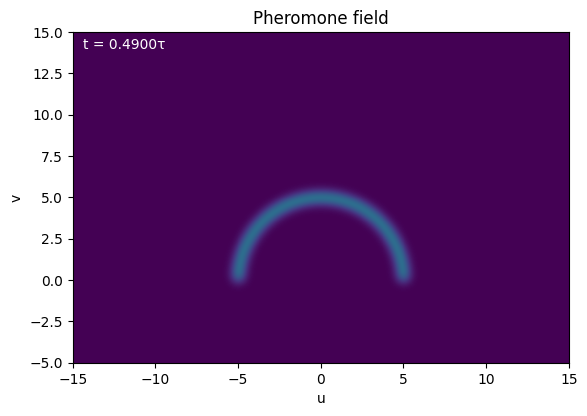

In [4]:
ani = field.animate(steps=50, interval=50)
ani.save("pheromone.mp4", writer="ffmpeg", fps=20)

In [5]:
ani.save("pheromone.mp4", writer="ffmpeg", fps=20,
         extra_args=["-vcodec", "libx264", "-preset", "ultrafast"])